# Applying ChirpGP on Interferometry Data

We are interested in sumulating the reflectance of growing thin films (forward modeling) and infer the growth behavior from measurements.

## Imports

In [15]:
# %pip install ..

# numerics
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import optax

# data reading
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# use latex for plotting
# plt.rc('text', usetex=True)

# use svg for plots
%config InlineBackend.figure_format = 'svg'

# our library
from reflax import polanalyze
from reflax.parameter_classes.parameters import OpticsParams, SetupParams, LayerParams, GrowthModel
from reflax.data_analysis import cws
from reflax.forward_model.variable_layer_size import forward_model

# chirp analysis
from reflax.data_analysis.chirpgp.wrapper import chirp_analyzer
from reflax.reflactance_models.baseline_methods import growth_from_frequencies
from reflax.data_analysis.chirpgp.models import g

## General Setup

Let us first specify parameters of the experimental setup

In [16]:
from reflax.parameter_classes.parameters import SetupParams

wavelength = 632.8
polar_angle = jnp.deg2rad(25)
azimuthal_angle = jnp.deg2rad(0)

setup_params = SetupParams(
    wavelength = wavelength,
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle
)

polarization_state = "Linear TE/perpendicular/s"
transverse_electric_component, transverse_magnetic_component = polanalyze(polarization_state)

We also generally assume

In [17]:
permeability_reflection = 1
permittivity_reflection = 1

permeability_transmission = 1
permittivity_transmission = (3.8827 + 0.019626j)**2

optics_params = OpticsParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection,
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission,
    transverse_electric_component = transverse_electric_component,
    transverse_magnetic_component = transverse_magnetic_component
)

backside_mode = 1

and consider a setup with one static-thickness layer with parameters

In [18]:
static_layer_thicknesses = jnp.array([0.0])
permeability_static_size_layers = jnp.array([1.0])
permittivity_static_size_layers = jnp.array([1.45704**2])

static_layer_params = LayerParams(
    permeabilities = permeability_static_size_layers,
    permittivities = permittivity_static_size_layers,
    thicknesses = static_layer_thicknesses
)

Let there further be a layer of variable thickness, with properties

In [19]:
permeability_variable_layer = 1
permittivity_variable_layer = 1.57**2

variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer
)

## True growth model for the variable layer

We simulate over the timespan

In [20]:
final_time = 7049 / 3600
dt = 0.001
time_points = jnp.arange(0, final_time, dt)

Given a linear growth rate

In [21]:
layer_growth_rate = 0.15 * 3600
layer_growth_acceleration = -100

this yields the following thicknesses of the variable layer

In [22]:
true_thicknesses = layer_growth_rate * time_points + 0.5 * layer_growth_acceleration * time_points**2
true_growth = layer_growth_rate + layer_growth_acceleration * time_points

## Running the simulation

In [23]:
true_reflectance = forward_model(
    model = 1,
    setup_params = setup_params,
    optics_params = optics_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = true_thicknesses,
    backside_mode = backside_mode,
    normalization = 1
)

# add noise
key = jax.random.PRNGKey(555)
key, subkey = jax.random.split(key)

# Generate chirp measurements
noise_std = 0.0001
noisy_reflectance = true_reflectance + jnp.sqrt(noise_std) * jax.random.normal(key, shape=(true_reflectance.size,))

In [29]:
from reflax._helpers.helpers import calculate_reflection_coeff, snell


n0 = jnp.sqrt(optics_params.permeability_reflection * optics_params.permittivity_reflection)
n1 = jnp.sqrt(variable_layer_params.permeabilities * variable_layer_params.permittivities)
n2 = jnp.sqrt(optics_params.permeability_transmission * optics_params.permittivity_transmission)

theta_transmitted = snell(n0, n1, setup_params.polar_angle)

r01 = calculate_reflection_coeff(n0, n1, setup_params.polar_angle, setup_params.polstate)
r12 = calculate_reflection_coeff(n1, n2, theta_transmitted, setup_params.polstate)
r10 = -calculate_reflection_coeff(n0, n1, theta_transmitted, setup_params.polstate)

print(r01, r12, r10)


-0.17167898554954159 (-0.405679298647332-0.0024888479883462566j) 0.1256537773537923


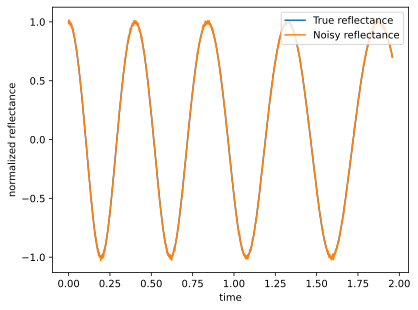

In [24]:
# plot the noisy reflectance
plt.plot(time_points, true_reflectance, label="True reflectance")
plt.plot(time_points, noisy_reflectance, label="Noisy reflectance")
plt.xlabel("time")
plt.ylabel("normalized reflectance")
plt.legend(loc = "upper right")

## Chirp Analysis on the Simulated Data

In [25]:
estimated_freqs_mean, smoothing_results = chirp_analyzer(noisy_reflectance, dt, noise_std)
estimated_growth = growth_from_frequencies(setup_params, optics_params, variable_layer_params.permeabilities, variable_layer_params.permittivities, estimated_freqs_mean)

Parameter learnt: [1.92150233e-03 1.00694591e-05 4.66124094e-01 6.49058820e-01
 1.13434398e+00 2.56505783e+00]. Convergence: ScipyMinimizeInfo(fun_val=Array(-6180.51768633, dtype=float64, weak_type=True), success=True, status=0, iter_num=35, hess_inv=LbfgsInvHessProduct(sk=[[-7.01665489e-04 -2.53375621e-01  7.23585801e-03  1.26490015e-04
  -6.73770570e-04  2.52823257e-03]
 [ 2.44572261e-04 -1.57510652e-01  7.19246502e-03 -1.08807749e-03
  -4.05465519e-04 -2.59017760e-03]
 [-1.71382207e-03 -2.56611308e-01 -1.34093281e-03  5.79831667e-04
   6.51973460e-04  3.33295967e-03]
 [-4.63515562e-04 -2.98909986e-01 -3.14578941e-03  1.29660531e-04
   2.82510133e-04  1.06479359e-03]
 [ 1.72738418e-02 -4.17583062e-01 -8.22410568e-02 -1.04259545e-02
  -1.30173353e-02  3.76892681e-05]
 [-5.93687244e-03 -2.31761597e-01 -3.99945324e-02 -5.30327802e-04
   1.63152213e-03  2.00672794e-03]
 [ 4.12463046e-03 -2.17277963e-01 -1.06082100e-02 -1.48577200e-03
  -2.18490550e-03 -1.09600450e-02]
 [-1.26541013e-02 -

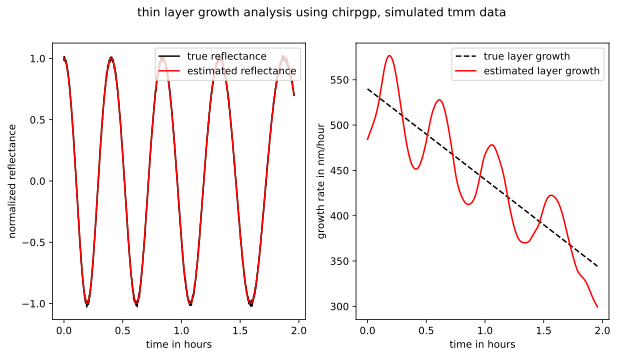

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# set figure title to thin layer growth analysis using chirpgp
fig.suptitle("thin layer growth analysis using chirpgp, simulated tmm data")

# on the first axis, plot the true normalized reflectance
ax1.plot(time_points, noisy_reflectance, label="true reflectance", color='black')
ax1.plot(time_points, smoothing_results[0][:, 1], label='estimated reflectance', color='red')
ax1.set_xlabel("time in hours")
ax1.set_ylabel("normalized reflectance")
ax1.legend(loc = "upper right")

# plot the estimated growth over time
ax2.plot(time_points, true_growth, "--", label="true layer growth", color='black')
ax2.plot(time_points, estimated_growth, label="estimated layer growth", color='red')
# plt.fill_between(time_points,
#     g(smoothing_results[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
#     g(smoothing_results[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
#     color='black',
#     edgecolor='none',
#     alpha=0.15
# )
ax2.set_xlabel("time in hours")
ax2.set_ylabel("growth rate in nm/hour")
ax2.legend(loc = "upper right")

In [27]:
# save the noisy reflectance and time points to npz files
np.savez("noisy_reflectance.npz", noisy_reflectance=noisy_reflectance)
np.savez("time_points.npz", time_points=time_points)

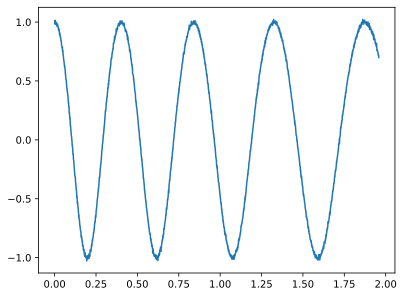

In [28]:
# load the noisy reflectance and time points from the npz files and plot them
noisy_reflectance = np.load("noisy_reflectance.npz")['noisy_reflectance']
time_points = np.load("time_points.npz")['time_points']

plt.plot(time_points, noisy_reflectance, label="Noisy reflectance")